# Physics 760: Computational Physics
## WS 2022/23
### Week 1

#### Pugazharasu Anancia Devaneyan, Rishi Kumar Senthil Kumar

In [2]:
#Importing libraries
import numpy as np
import math as mth
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from statistics import mean
import random
from scipy.misc import derivative


In [3]:
#To enable MathTex
plt.rcParams['text.usetex'] = True
mpl.rcParams.update(mpl.rcParamsDefault)

# Finding the exact solution

We shall use the equations given in the exercise sheet and Sympy to obtain the exact solution for the average magnetization.

In [4]:
from sympy import *

J, h, T, N = symbols('J h T N')

init_printing(use_unicode=True)

In [5]:
lambda_plus = exp(J/T)*(cosh(h/T)+sqrt((sinh(h/T)**2)+exp(-4*(J/T))))
lambda_minus = exp(J/T)*(cosh(h/T)-sqrt((sinh(h/T)**2)+exp(-4*(J/T))))
Z = (lambda_plus**N) + (lambda_minus**N)

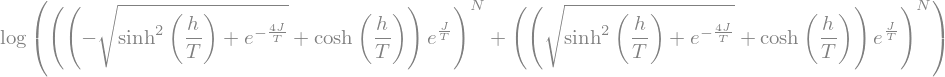

In [6]:
A = ln(Z)
display(A)

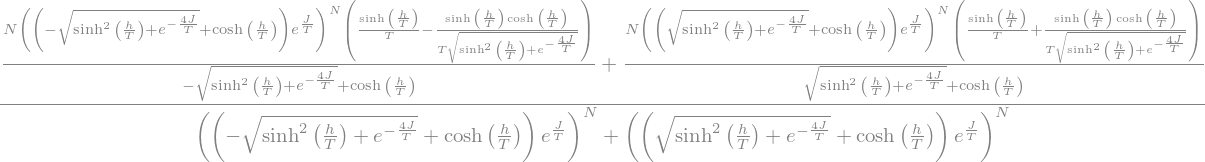

In [7]:
diff(A, h)

In [8]:
def exact_magnetization(J,h,T,N):
    mag = 0 
    sine_term = mth.sin(h/T)
    cosine_term = mth.cos(h/T)
    exp_term = mth.exp(J/T)
    numerator_first = (N*(((cosine_term - mth.sqrt((sine_term**2)+(exp_term**(-4))))*exp_term)**N)*((sine_term/T)-((sine_term*cosine_term)/(T*mth.sqrt((sine_term**2)+(exp_term**(-4)))))))/(cosine_term - mth.sqrt((sine_term**2)+(exp_term**(-4))))
    numerator_second = (N*(((cosine_term + mth.sqrt((sine_term**2)+(exp_term**(-4))))*exp_term)**N)*((sine_term/T)+((sine_term*cosine_term)/(T*mth.sqrt((sine_term**2)+(exp_term**(-4)))))))/(cosine_term + mth.sqrt((sine_term**2)+(exp_term**(-4))))
    denom_first = (((-mth.sqrt((sine_term**2)+(exp_term)**(-4))+cosine_term)*exp_term)**N)
    denom_second = (((mth.sqrt((sine_term**2)+(exp_term)**(-4))+cosine_term)*exp_term)**N)
    mag = (numerator_first + numerator_second)/(denom_first + denom_second)
    return mag

We shall now calculate the magnetization at the thermodynamic limit.

In [9]:
def thermo_magnetization(J,h,T):
    sine_term = mth.sin(h/T)
    cosine_term = mth.cos(h/T)
    exp_term = mth.exp(-4*(J/T))
    mag = (sine_term + ((sine_term * cosine_term)/(mth.sqrt((sine_term**2)+exp_term))))/(cosine_term + mth.sqrt((sine_term**2)+exp_term))
    return mag

# II Numerics

## Randomly generating a $\mathbb{Z}_{2}$ lattice with periodic boundary conditions

In [10]:
def generate_spins(N):
    #generate random spin config
    spin_list = 2*np.random.randint(2, size = (N))-1
    
    #Check for boundary conditions
    spin_list[0] = spin_list[N-1]
    
    return spin_list

## Defining what the average energy of a lattice is

In [26]:
"""
def energy(N,J,h,spin_list):
    e_out = 0.0
    length = len(spin_list)
    for i in range(0,length-1):
        spin_i = int(spin_list[i])
        spin_i1 = int(spin_list[i+1])
        if (i+1) < length:
            e_out = e_out - (J*(spin_i*spin_i1)) - (h*spin_i)
        else:
            e_out = e_out - (h*spin_i)
    return e_out
"""

In [73]:
def energy(N,J,h,spin_list):
    num_spins = len(spin_list)
    e_out = 0.0
    for i in range(num_spins):
        spini = spin_list[i]
        #set the value of spin i+1, make sure to test if i+1<num_spins, and otherwise account for periodic boundaries
        #you can do this with an if statement if you have to
        ip1 = (i+1)%num_spins
        spinip1 = spin_list[ip1]
        e_out = e_out - (J * (spini * spinip1)) - h*spini
        
    return e_out

In [12]:
"""
def energy_diff(spin_list, spin_list_updated,N,J,h):
    diff = -energy(N,J,h,spin_list) + energy(N,J,h,spin_list_updated)
    return diff
"""

In [78]:
def energy_diff(si,sleft,sright,J,h):
    dE = 2*h*si + 2*J*si*(sleft+sright)
    return dE

In [13]:
def spin_flip_probability(delta_e, T):
    flip_prob = np.exp(-1*((delta_e/T)))
    return flip_prob

In [14]:
def spin_flip(site, lattice):
    if lattice[site-1] == 1:
        lattice[site-1] = -1
        return lattice
    else:
        lattice[site-1] = 1
        return lattice

In [24]:
"""
def accept_reject(J,h,T,N,sweeps):
    current_config = generate_spins(N)
    random_site_1 = np.random.randint(0,N-1)
    updated_config = spin_flip(random_site_1, current_config)
    delta_energy = 0
    for j in range(0,sweeps-1):
        delta_energy = energy_diff(current_config, updated_config, N,J,h)
        random_number = random.uniform(0, 1)
        if (delta_energy < 0) or (random_number<spin_flip_probability(delta_energy, T)):
            current_config = updated_config
        else:
            pass
        random_site = np.random.randint(0,N-1)
        spin_flip(random_site, current_config)
    return updated_config
"""    

In [83]:
display(random.uniform(0, 1))

In [87]:
def accept_reject(J,h,T,N,sweeps):
    current_config = generate_spins(N)
    random_site_1 = np.random.randint(0,N-1)
    updated_config = spin_flip(random_site_1, current_config)
    delta_energy = 0
    for j in range(sweeps):
        si = current_config[random_site_1]
        sright = current_config[(random_site_1+1)%N]
        sleft = current_config[(random_site_1-1)%N]
        delta_energy = energy_diff(si,sleft,sright,J,h)
        random_number = random.uniform(0, 1)
        if random_number<min(1,spin_flip_probability(delta_energy, T)):
            current_config = updated_config
        else:
            pass
        random_site = np.random.randint(0,N-1)
        spin_flip(random_site, current_config)
    return updated_config

In [106]:
display(accept_reject(1,2,3,4,8))

array([-1, -1,  1,  1])

In [89]:
def numerical_mag(spin_list):
    return spin_list.mean()

In [114]:
h_input = np.linspace(-1,1,10)
h_fixed = 0.5
N_fixed = 70
N_input = [2,3,4,5,6,7]
T = 2
J_fixed = 1
sweeps = 14

# Plotting $\langle m \rangle$ versus h

In [115]:
#Corresponding y-axis values
m_1 = []
m_thermo_1 = []
m_exact_1 = []
for i in h_input:
    m_1.append(numerical_mag(accept_reject(J_fixed,i,T,N_fixed,sweeps)))
    m_thermo_1.append(thermo_magnetization(J_fixed,i,T))
    m_exact_1.append(exact_magnetization(J_fixed,i,T,N_fixed))

In [109]:
print(m_1)

[0.2, -0.02857142857142857, 0.02857142857142857, -0.2, -0.05714285714285714, -0.05714285714285714, 0.0, 0.02857142857142857, -0.05714285714285714, -0.17142857142857143, 0.2, 0.08571428571428572, 0.17142857142857143, 0.0, 0.05714285714285714, 0.02857142857142857, 0.11428571428571428, 0.08571428571428572, -0.05714285714285714, -0.17142857142857143, -0.08571428571428572, 0.0, 0.02857142857142857, 0.11428571428571428, 0.05714285714285714, 0.14285714285714285, 0.0, -0.08571428571428572, -0.02857142857142857, 0.17142857142857143, -0.02857142857142857, -0.08571428571428572, 0.2, 0.11428571428571428, -0.08571428571428572, -0.02857142857142857, 0.14285714285714285, 0.17142857142857143, 0.08571428571428572, -0.05714285714285714, -0.02857142857142857, -0.2, 0.02857142857142857, 0.0, -0.02857142857142857, -0.11428571428571428, 0.02857142857142857, 0.0, -0.17142857142857143, 0.2571428571428571, 0.14285714285714285, 0.02857142857142857, 0.0, -0.02857142857142857, 0.22857142857142856, 0.0285714285714

In [222]:
m_2 = []
m_thermo_2 = []
m_exact_2 = []
for j in N_input:
    m_2.append(numerical_mag(accept_reject(J_fixed,h_fixed,T,int(i),sweeps)))
    m_thermo_2.append(thermo_magnetization(J_fixed,h_fixed,T))
    m_exact_2.append(exact_magnetization(J_fixed,h_fixed,T,i))

ValueError: high <= 0

No handles with labels found to put in legend.


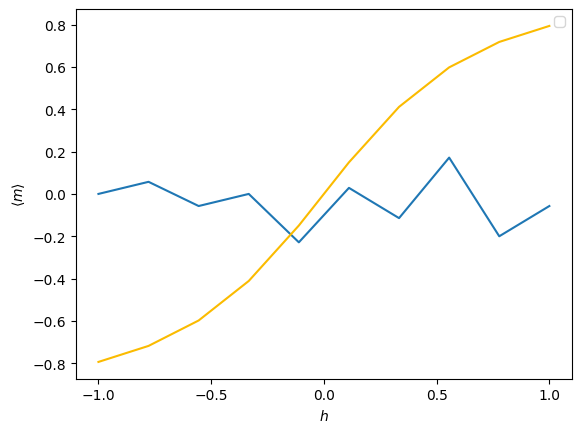

In [117]:
#Corresponding y-axis values

#Plotting the points 
plt.plot(h_input, m_1)

plt.plot(h_input, m_thermo_1, color ='#fbbb00')

#plt.plot(h_input, m_exact_1, color = '#949387')
  
#Labeling the x axis
plt.xlabel(r'$h$')

#Labeling the y axis
plt.ylabel(r'$\langle m \rangle$')

#Titling the plot
#plt.title(r'Angular distribution for the process: $e^{+}e^{-} \rightarrow \mu^{+}\mu^{-}$', size = 13)

plt.xticks(np.arange(-1.0, 1.5, 0.5))
plt.legend(loc='upper right')
#plt.savefig('ee_mm.png')
plt.show()

In [ ]:
#Corresponding y-axis values
m_1 = numerical_mag(accept_reject(J_fixed,h_input,T,N_fixed,sweeps))

#Plotting the points 
plt.plot(h_input, m_1, label=r'$s$-channel', color='#0a55a1')
  
#Labeling the x axis
plt.xlabel(r'$\cos{(\theta)}$')

#Labeling the y axis
plt.ylabel(r'$\frac{d \sigma}{d \Omega}$')

#Titling the plot
plt.title(r'Angular distribution for the process: $e^{+}e^{-} \rightarrow \mu^{+}\mu^{-}$', size = 13)

plt.xticks(np.arange(-1.0, 1.5, 0.5))
plt.legend(loc='upper right')
plt.savefig('ee_mm.png')
plt.show()